In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

In [2]:
# Download latest version
path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")

print("Path to dataset files:", path)

100%|██████████| 723M/723M [00:12<00:00, 60.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/irkaal/foodcom-recipes-and-reviews/versions/2


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dfRec = pd.read_csv(os.path.join(path, 'recipes.csv'))
dfRev = pd.read_csv(os.path.join(path, 'reviews.csv'))

In [ ]:
dfRev.head(25)
# print(dfRev['Review'].head(10).tolist())

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
5,17,5221,2046,Gay Gilmore ckpt,4,"love it, but without the bean sprouts.",2000-05-08T11:08:00Z,2000-05-08T11:08:00Z
6,19,13307,2046,Gay Gilmore ckpt,5,"chewy goodness, not crispy at all. i even thre...",2000-05-21T16:59:00Z,2000-05-21T16:59:00Z
7,21,148,2156,Darlene Blythe,0,Would someone please check the Nutrition Facts...,2000-06-02T10:01:00Z,2000-06-02T10:01:00Z
8,22,517,2046,Gay Gilmore ckpt,5,thought this was terrific!,2000-02-25T09:02:00Z,2000-02-25T09:02:00Z
9,23,4684,2046,Gay Gilmore ckpt,5,this is absolutely delicious. i even served i...,2000-02-25T09:06:00Z,2000-02-25T09:06:00Z


In [ ]:
print(dfRev['Review'].head(25).tolist())

['better than any you can get at a restaurant!', 'I cut back on the mayo, and made up the difference with sour cream to adjust the stiffness of the dip.', 'i think i did something wrong because i could taste the cornstarch in the finished product.', 'easily the best i have ever had.  juicy flavorful, not dry.  the vegetables retain crispness as well, not bland at all!', 'An excellent dish.', 'love it, but without the bean sprouts.', 'chewy goodness, not crispy at all. i even threw in craisins and left the oatmeal whole, and they were great.', 'Would someone please check the Nutrition Facts of this recipe.', 'thought this was terrific!', 'this is absolutely delicious.  i even served it with lime slices so you could squeeze on more of the acid.', 'a little greasy, but a huge hit with the guests.', 'leeks on a pizza?!  it was really delicious.  i used a boboli and added some chicken sausage slices and mushrooms too.', 'I deleted the bean sprouts and replaced them with salted cashew nuts..

In [6]:
dfRec.head(10)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."
5,43,Best Blackbottom Pie,34879,Barefoot Beachcomber,PT2H,PT20M,PT2H20M,1999-08-21T10:35:00Z,Make and share this Best Blackbottom Pie recip...,character(0),Pie,"c(""Dessert"", ""Weeknight"", ""Stove Top"", ""< 4 Ho...","c(""1 1/4"", ""1/4"", ""6"", ""1/3"", ""1/4"", ""1/4"", ""2...","c(""graham cracker crumbs"", ""sugar"", ""butter"", ...",1.0,1.0,437.9,19.3,10.9,94.3,267.6,58.0,1.8,42.5,7.0,8.0,1 9-inch pie,"c(""Graham Cracker Crust: In small bowl, combin..."
6,44,Warm Chicken A La King,1596,Joan Edington,PT3M,PT35M,PT38M,1999-09-17T04:47:00Z,I copied this one out of a friend's book so ma...,"""https://img.sndimg.com/food/image/upload/w_55...",Chicken,"c(""Poultry"", ""Meat"", ""< 60 Mins"")","c(""12"", ""2"", ""3"", ""450"", ""1"", ""2"", ""1/4"", ""1"",...","c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...",5.0,23.0,895.5,66.8,31.9,405.8,557.2,29.1,3.1,5.0,45.3,2.0,NaN,"c(""Melt 1 1/2 ozs butter, add the flour and co..."
7,45,Buttermilk Pie With Gingersnap Crumb Crust,1580,tristitia,PT50M,PT30M,PT1H20M,1999-08-06T00:40:00Z,Make and share this Buttermilk Pie With Ginger...,"""https://img.sndimg.com/food/image/upload/w_55...",Pie,"c(""Dessert"", ""Healthy"", ""Weeknight"", ""Oven"", ""...","c(""3/4"", "

In [ ]:
# print(dfRec['Images'].head(10).tolist())
print(dfRec[dfRec['RecipeId'] == 992])

     RecipeId                     Name  AuthorId     AuthorName CookTime  \
702       992  Jalapeno Pepper Poppers      1545  Nancy Van Ess      NaN   

    PrepTime TotalTime         DatePublished  \
702    PT30M     PT30M  1999-09-06T04:28:00Z   

                                           Description  \
702  Make and share this Jalapeno Pepper Poppers re...   

                                                Images  ...  \
702  "https://img.sndimg.com/food/image/upload/w_55...  ...   

    SaturatedFatContent CholesterolContent SodiumContent CarbohydrateContent  \
702                 4.9               23.7         172.5                 3.2   

     FiberContent  SugarContent  ProteinContent  RecipeServings  RecipeYield  \
702           0.6           0.9             4.3            24.0          NaN   

                                    RecipeInstructions  
702  c("In a mixing bowl, combine cheeses, bacon an...  

[1 rows x 28 columns]


# Data Exploration

## Recipe Dataset

In [5]:
dfRec.info()
dfRec.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


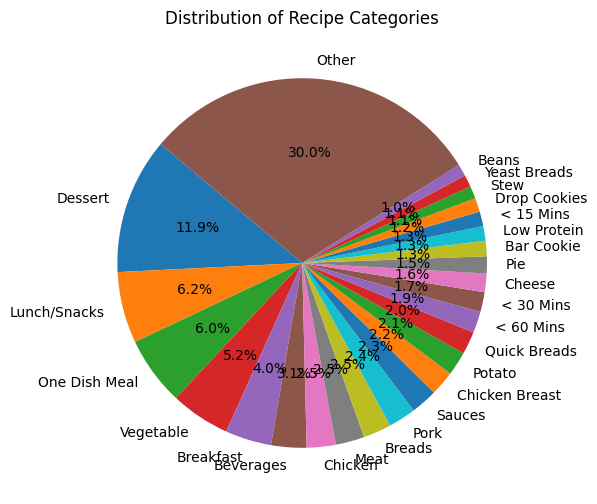

In [25]:
recipe_category_counts = dfRec['RecipeCategory'].value_counts()
top_10_counts = recipe_category_counts.head(25) # Select only the top 25 categories
other_count = recipe_category_counts.iloc[25:].sum()
top_10_with_other = pd.concat([top_10_counts, pd.Series({'Other':other_count})])

plt.figure(figsize=(10, 6))
plt.pie(top_10_with_other, labels=top_10_with_other.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Recipe Categories')
plt.show()

### Data Cleaning

In [27]:
dfRec.drop(columns=['Images'], inplace=True)
dfRec.drop(columns=['RecipeYield'], inplace=True) # Too many nulls

# Deal with null values:
dfRec['CookTime'].fillna(0, inplace=True) # NaN means no cooking required
dfRec['ReviewCount'].fillna(0, inplace=True) # NaN means no reviews
dfRec['AggregatedRating'].fillna(2.5, inplace=True) # Use a neutral value even though median is 5.0 and mean 4.6 since we have no indication of quality
dfRec['RecipeServings'].fillna(dfRec['RecipeServings'].median(), inplace=True)
dfRec['Description'].fillna('', inplace=True) # Put empty description
dfRec['RecipeCategory'].fillna(dfRec['Name'], inplace=True) # Substitute category with recipe name
dfRec['Keywords'].fillna(dfRec['RecipeIngredientParts'], inplace=True) # Substitute with ingredients, any better ideas?
dfRec['RecipeIngredientQuantities'].fillna('c("0")',inplace=True) # There are only 3 missing

dfRec.info()

<ipython-input-27-a1527c8a7b97>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfRec['CookTime'].fillna(0, inplace=True) # NaN means no cooking required
<ipython-input-27-a1527c8a7b97>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    522517 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522517 non-null  object 
 9   RecipeCategory              522517 non-null  object 
 10  Keywords                    522517 non-null  object 
 11  RecipeIngredientQuantities  522517 non-null  object 
 12  RecipeIngredientParts       522517 non-null  object 
 13  AggregatedRati

In [28]:
dfRec.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000
mean,271821.436970,4.572585e+07,3.598794,2.751656,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,7.693874
std,155495.878422,2.929714e+08,1.160894,15.015307,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,92.171835
min,38.000000,2.700000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,2.500000,0.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,3.000000,1.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,2.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,6.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


### Dataset Splitting and Scaling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

num_feature_columns = [
    'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
    'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent',
    'ProteinContent', 'RecipeServings'
]

train_recipe_data, test_recipe_data = train_test_split(dfRec, test_size=0.2, random_state=42)
recipe_scaler = StandardScaler()

train_recipe_data[num_feature_columns] = recipe_scaler.fit_transform(train_recipe_data[num_feature_columns])
test_recipe_data[num_feature_columns] = recipe_scaler.transform(test_recipe_data[num_feature_columns]) # Use fit from trainig data to prevent data leakage

## Review Dataset

In [33]:
dfRev.info()
dfRev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


,ReviewId,RecipeId,AuthorId,Rating
count,1.401982e+06,1.401982e+06,1.401982e+06,1.401982e+06
mean,8.179739e+05,1.526412e+05,1.558638e+08,4.407951e+00
std,5.280821e+05,1.301112e+05,5.305111e+08,1.272012e+00
min,2.000000e+00,3.800000e+01,1.533000e+03,0.000000e+00
25%,3.743862e+05,4.703875e+04,1.336800e+05,4.000000e+00
50%,7.717805e+05,1.093270e+05,3.305450e+05,5.000000e+00
75%,1.204126e+06,2.318768e+05,8.183590e+05,5.000000e+00
max,2.090347e+06,5.412980e+05,2.002902e+09,5.000000e+00


### Data Cleaning

In [34]:
dfRev['Review'].fillna('', inplace=True) # Put empty description for now
dfRev.info()

<ipython-input-34-18a7909015b7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfRev['Review'].fillna('', inplace=True) # Put empty description for now


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401982 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


<Axes: ylabel='Frequency'>

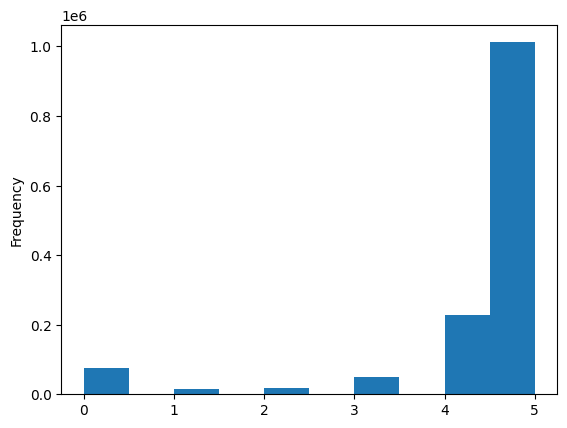

In [35]:
dfRev['Rating'].plot(kind='hist')

In [36]:
train_review_data, test_review_data = train_test_split(dfRev, test_size=0.2, random_state=42)
review_scaler = StandardScaler() # tried QuantileTransformer and PowerTransformer but the data is still very skewed


train_review_data['Rating'] = review_scaler.fit_transform(train_review_data['Rating'].values.reshape(-1, 1))
test_review_data['Rating'] = review_scaler.transform(test_review_data['Rating'].values.reshape(-1, 1)) # Use fit from trainig data to prevent data leakage

# User and Recipe Embeddings

In [32]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

review_embeddings = model.encode(dfRev['Review'].tolist())
print(review_embeddings.shape)

KeyboardInterrupt: 

In [ ]:
print(review_embeddings[0])

NameError: name 'review_embeddings' is not defined

# Model Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoTowerRecommendationSystem(nn.Module):
    def __init__(self,
                 recipe_vocab_sizes, review_vocab_sizes,
                 embedding_dim, numerical_dims):
        super(TwoTowerRecommendationSystem, self).__init__()

        # Embeddings for Recipe Tower
        self.recipe_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in recipe_vocab_sizes.items()
        })

        # Embeddings for Review Tower
        self.review_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in review_vocab_sizes.items()
        })

        # Recipe Tower Network
        recipe_input_dim = len(recipe_vocab_sizes) * embedding_dim + numerical_dims['recipe']
        self.recipe_fc = nn.Sequential(
            nn.Linear(recipe_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Review Tower Network
        review_input_dim = len(review_vocab_sizes) * embedding_dim + numerical_dims['review']
        self.review_fc = nn.Sequential(
            nn.Linear(review_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, recipe_inputs, review_inputs):
        # Recipe Tower
        recipe_embeds = [
            self.recipe_embeddings[key](value)
            for key, value in recipe_inputs['categorical'].items()
        ]
        recipe_embeds = torch.cat(recipe_embeds, dim=-1)
        recipe_combined = torch.cat([recipe_embeds, recipe_inputs['numerical']], dim=-1)
        recipe_output = self.recipe_fc(recipe_combined)

        # Review Tower
        review_embeds = [
            self.review_embeddings[key](value)
            for key, value in review_inputs['categorical'].items()
        ]
        review_embeds = torch.cat(review_embeds, dim=-1)
        review_combined = torch.cat([review_embeds, review_inputs['numerical']], dim=-1)
        review_output = self.review_fc(review_combined)

        # Calculate similarity (dot product or cosine similarity)
        similarity = F.cosine_similarity(recipe_output, review_output, dim=-1)

        return similarity

# Training